# DeFactify 📰 - Iteration 1

This notebook is dedicated to developing a `Fake News Detection system` using machine learning techniques.

Let's begin by importing the libraries and checking their versions.

In [385]:
import nltk
import numpy
import pandas
import sklearn
import seaborn

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn import preprocessing

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Library versions:")
print("- nltk:", nltk.__version__)              # 3.9.1
print("- numpy:", numpy.__version__)            # 2.1.3
print("- pandas:", pandas.__version__)          # 2.2.3
print("- sklearn:", sklearn.__version__)        # 1.6.1
print("- seaborn:", seaborn.__version__)        # 0.13.2


Library versions:
- nltk: 3.9.1
- numpy: 2.1.3
- pandas: 2.2.3
- sklearn: 1.6.1
- seaborn: 0.13.2


## Data provisioning 📦
Let's start by loading all the CSV files containing the articles. We will begin with the BBC data, which I scraped from each day as indicated by the file names. I was unable to find any pages on the BBC with multiple pages; all the content comes from the main page.

### Real News ✅ 

In [386]:
bbc1 = pandas.read_csv('scraper/dataset/bbc_23.03.25_real.csv')
bbc1.shape

(36, 8)

In [387]:
bbc2 = pandas.read_csv('scraper/dataset/bbc_24.03.25_real.csv')
bbc2.shape

(38, 8)

In [388]:
bbc3 = pandas.read_csv('scraper/dataset/bbc_27.03.25_real.csv')
bbc3.shape

(38, 8)

In [389]:
bbc4 = pandas.read_csv('scraper/dataset/bbc_31.03.25_real.csv')
bbc4.shape

(38, 8)

In [390]:
bbc5 = pandas.read_csv('scraper/dataset/bbc_06.04.25_real.csv')
bbc5.shape

(41, 8)

In [391]:
bbc6 = pandas.read_csv('scraper/dataset/bbc_07.04.25_real.csv')
bbc6.shape

(40, 8)

In [392]:
ap = pandas.read_csv('scraper/dataset/apnews_real.csv', encoding='latin1')
ap.shape

(240, 8)

In [393]:
tech = pandas.read_csv('scraper/dataset/techcrunch_real.csv')
tech.shape

(135, 8)

### Fake News ❌

In [394]:
onion = pandas.read_csv('scraper/dataset/the_onion_fake.csv')
onion.shape

(130, 8)

In [395]:
spacexmania = pandas.read_csv('scraper/dataset/spacexmania_fake.csv', encoding='latin1')
spacexmania.shape

(149, 8)

In [396]:
peoples_voice = pandas.read_csv('scraper/dataset/peoples_voice_fake.csv')
peoples_voice.shape

(100, 8)

In [397]:
intel_drop = pandas.read_csv('scraper/dataset/intel_drop_fake.csv', encoding='latin1')
intel_drop.shape

(102, 8)

### Combination of all CSV files 📥

In [398]:
combined_dataset = pandas.concat([bbc1, bbc2, bbc3, bbc4, bbc5, bbc6, onion, spacexmania, peoples_voice, intel_drop, ap, tech])
combined_dataset.shape

(1087, 8)

## Sample the data 📃

In [399]:
combined_dataset.sample(10)

,Title,URL,Source,Journalist(s),Published Date,Content,Category,Label
231,This Midwestern city has long been a federal h...,https://apnews.com/newsletter/ground-game/apri...,AP News,Ryan J. Foley,20-04-25,"KANSAS CITY, Mo. (AP) â In her 28 years work...",Economy,1
132,Famed AI researcher launches controversial sta...,https://techcrunch.com/2025/04/19/famed-ai-res...,TechCrunch,Julie Bort,19-04-25,"Every now and then, a Silicon Valley startup l...",Technology,1
17,Deadly US airstrike on Yemeni oil port escalat...,https://apnews.com/article/yemen-us-airstrikes...,AP News,Jon Gambrell,19-04-25,"DUBAI, United Arab Emirates (AP) â A U.S. ai...",World News,1
84,Zoom restores service after an hours-long outage,https://techcrunch.com/2025/04/16/zoom-restore...,TechCrunch,NaN,16-04-25,Posted:\n\nZoom says its platform is back onli...,Technology,1
151,Nate Bargatze will host the 2025 Emmy Awards,https://apnews.com/newsletter/ground-game/apri...,AP News,NaN,16-04-25,LOS ANGELES (AP) â Stand-up comedianNate Bar...,Entertainment,1
211,Tax tips for recently married couples and firs...,https://apnews.com/newsletter/ground-game/apri...,AP News,Adriana Morga,13-04-25,NEW YORK (AP) â Taxes may not be the first t...,Economy,1
16,Four lingering questions about Trump officials...,https://www.bbc.com/news/articles/c5y41xdrxnyo,BBC,Kayla Epstein,27-03-25,"For the past 48 hours, top White House officia...",Politics,1
174,Archaeologists uncover the oldest known partia...,https://apnews.com/newsletter/ground-game/apri...,AP News,Christina Larson,12-03-25,WASHINGTON (AP) â A fossil of a partial face...,Science,1
3,Man Already Having Bad Day Deported To Salvado...,https://theonion.com/man-already-having-bad-da...,The Onion,NaN,3-04-25,"TECOLUCA, EL SALVADOR—Saying things had only g...",Crime,0
57,NATO Warns ‘Climate Change’ Could Spark World ...,https://thepeoplesvoice.tv/nato-warns-climate-...,The People's Voice,Sean Adl-Tabatabai,31-03-25,NATO has issued a stark warning: climate chang...,Environment,0


## Preprocessing 🛠️

Before training the algorithm, it is essential to ensure that the dataset is clean and free of any issues. 

We can achieve this by checking for any rows that contain missing data and if we find any, we decide to remove them or not.

In [400]:
combined_dataset.isnull().sum()

Title               0
URL                 0
Source              0
Journalist(s)     268
Published Date     19
Content            39
Category            4
Label               0
dtype: int64

In this case, it is acceptable not to have any listed journalists, as it is common for fake news articles to lack authors. The absence of a publication date is also not a significant issue. However, the content is a key aspect we will analyse, so when either the content or the category is missing, we can discard those rows of data.

In [401]:
cleaned_dataset = combined_dataset.dropna(subset=['Content', 'Category'])

cleaned_dataset.shape

(1048, 8)

It would be helpful to check for duplicated news titles, as I have noticed that some titles reappear multiple times. This way, we can remove them.

In [402]:
duplicate_titles = cleaned_dataset[cleaned_dataset.duplicated(subset=['Title'], keep=False)]

print(f"Number of duplicated titles: {duplicate_titles.shape[0]}")

Number of duplicated titles: 187


In [403]:
cleaned_dataset = cleaned_dataset.drop_duplicates(subset=['Title'], keep='first')

cleaned_dataset.shape

(940, 8)

In this iteration, I personally scraped the data, so I am familiar with most of the column information. However, to ensure everything is accurate, I am conducting a final check to confirm that the data contains only 0s and 1s. Overall, the data appears to be evenly distributed between fake and real news.

In [404]:
group_info = cleaned_dataset.groupby(["Label"])["Label"].count()
group_info

Label
0    456
1    484
Name: Label, dtype: int64

In [405]:
print(f"The dataset consists of {cleaned_dataset.shape[0]} rows.")

The dataset consists of 940 rows.


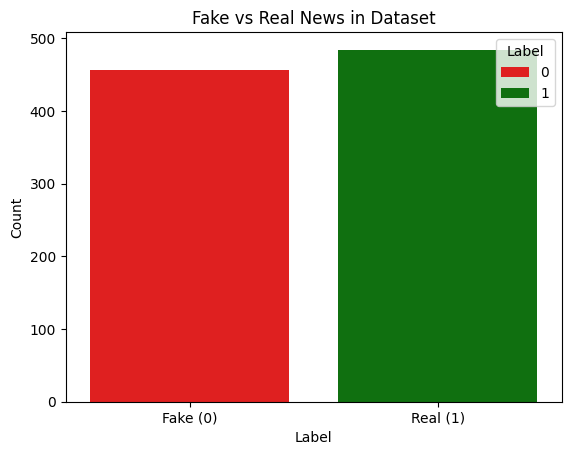

In [406]:
plt.figure()
seaborn.countplot(
    data=cleaned_dataset,
    x='Label',
    hue='Label', 
    palette={0: 'red', 1: 'green'},
)
plt.title('Fake vs Real News in Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Fake (0)', 'Real (1)'])
plt.show()


Since machine learning algorithms operate exclusively with numerical data and generate numerical outputs, the first step is to ensure that the target variable is numeric. Therefore, we need to convert the `Category` variable into numbers, but first let's visualise the categories and see how much we have from each.

In [407]:
category_counts = cleaned_dataset['Category'].value_counts()

category_table = category_counts.reset_index()
category_table.columns = ['Category', 'Count']

print(category_table)

         Category  Count
0        Politics    302
1   Entertainment    119
2          Sports    116
3      Technology    114
4      World News     80
5         Science     72
6         Economy     63
7  Human Interest     27
8           Crime     24
9     Environment     23


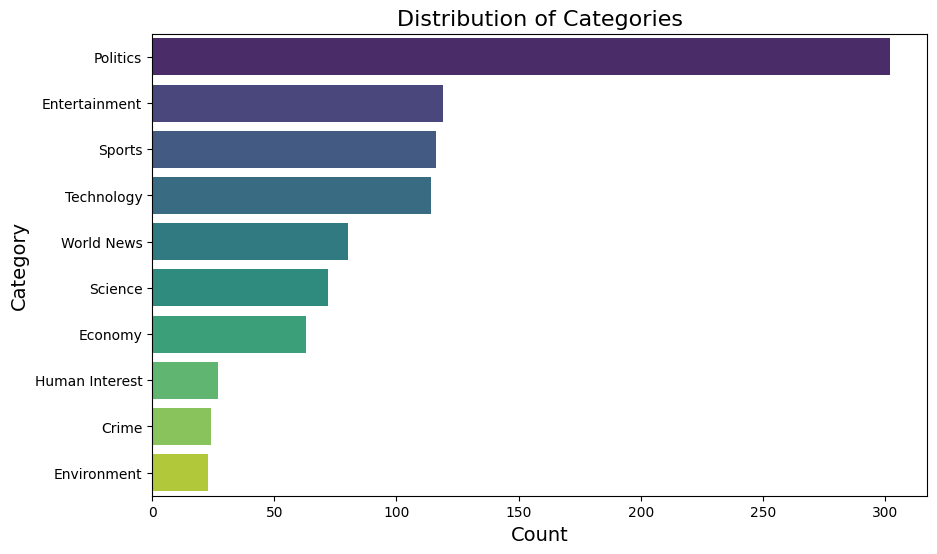

In [408]:
plt.figure(figsize=(10, 6))
seaborn.barplot(
    data=category_table,
    x='Count',
    y='Category',
    hue='Category', 
    palette='viridis'
)

plt.title('Distribution of Categories', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.show()

In [409]:
encoder = preprocessing.LabelEncoder()

cleaned_dataset.loc[:, "Category"] = encoder.fit_transform(cleaned_dataset["Category"])

cleaned_dataset.sample(10)

,Title,URL,Source,Journalist(s),Published Date,Content,Category,Label
100,"Bluesky feed builder Graze raises $1M, rolls o...",https://techcrunch.com/2025/04/16/bluesky-feed...,TechCrunch,Sarah Perez,16-04-25,"Graze, a startup that lets people build and mo...",8,1
83,Ontario Premier Declares War on U.S.: ‘We’ll I...,https://thepeoplesvoice.tv/ontario-premier-dec...,The People's Voice,Sean Adl-Tabatabai,28-03-25,Ontario Premier Doug Ford has declared economi...,5,0
184,Crocodile attacks in Indonesia are on the rise...,https://apnews.com/newsletter/ground-game/apri...,AP News,NaN,17-03-25,"BUDONG-BUDONG, Indonesia (AP) â Nearly seven...",6,1
141,Book Review: How would Joan Didion feel about ...,https://apnews.com/newsletter/ground-game/apri...,AP News,Anita Snow,21-04-25,What would Joan think? Reading the newly relea...,2,1
166,More pharmacies offer to speed prescription de...,https://apnews.com/newsletter/ground-game/apri...,AP News,Tom Murphy,20-04-25,Americaâs two largest retailers want to deli...,6,1
28,Israeli air strike kills top Hamas official in...,https://www.bbc.com/news/articles/cq5zxe5l58go,BBC,Rushdi Abu Alouf,23-03-25,An Israeli air strike on the southern city of ...,5,1
0,Is the world heading into recession?,https://www.bbc.com/news/articles/c24q15d9yq0o,BBC,Simon Jack,7/4/2025,US President Donald Trump's tariffs have ignit...,1,1
116,Santa Confirms Everyone Getting Bag Of Glitter...,https://theonion.com/santa-confirms-everyone-g...,The Onion,NaN,23-12-24,LAS VEGAS—Stressing how much it meant to Mrs. ...,9,0
73,OpenAI’s Stargate project sets its sights on i...,https://techcrunch.com/2025/04/17/openais-star...,TechCrunch,NaN,17-04-25,"Posted:\n\nStargate, a $500 billion project he...",8,1
11,Zimbabwe to scrap tariffs on US goods to build...,https://www.bbc.com/news/articles/c62xqel9l18o,BBC,Farouk Chothia,6/4/2025,Zimbabwe's President Emmerson Mnangagwa has an...,5,1


### Stopwords 🛑
Stopwords are the most commonly used words in a language, such as "in," "on," "a," "an," and "the" in English. 
When evaluating whether an article is fake or not, we do not need these words, so we can choose to remove them.

In [410]:
stemmer = PorterStemmer()

stop_words = set(stopwords.words('English'))

print(stopwords.words('English'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

### Stemming 🌱

Stemming is a technique that helps algorithms function more effectively. It reduces words to their root form. For instance, the words "programming" "programmer" and "programs" can all be reduced to the common word stem "program."

In [411]:
stemmer = PorterStemmer()

stop_words = set(stopwords.words('English'))

def preprocess_and_stem(text):
    # tokenize the text, convert to lowercase and remove punctuation
    tokens = word_tokenize(text.lower())
    # remove stopwords and apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]

    return ' '.join(stemmed_tokens)

In [412]:
cleaned_dataset['Title'] = cleaned_dataset['Title'].astype(str).apply(preprocess_and_stem)
cleaned_dataset['Content'] = cleaned_dataset['Content'].astype(str).apply(preprocess_and_stem)

print(cleaned_dataset[['Title', 'Content']].head())

                                               Title  \
0     istanbul mayor arrest ahead select run erdogan   
1    kill gaza sinc israel offens began ministri say   
2              ferrari hamilton disqualifi chines gp   
3            life spent wait search row unclaim bodi   
5  us hope progress peac talk three kill russian ...   

                                             Content  
0  main rival turkey presid recep tayyip erdogan ...  
1  palestinian kill israel militari campaign gaza...  
2  lewi hamilton finish sixth chines grand prix s...  
3  saira baloch 15 step morgu first time heard ro...  
5  imogen jamesl report upcom peac talk ukrain wa...  


### Word Cloud ☁️
Let's visualise the most used words in both fake and real media, when it comes to the `Title` and `Content` of the news.

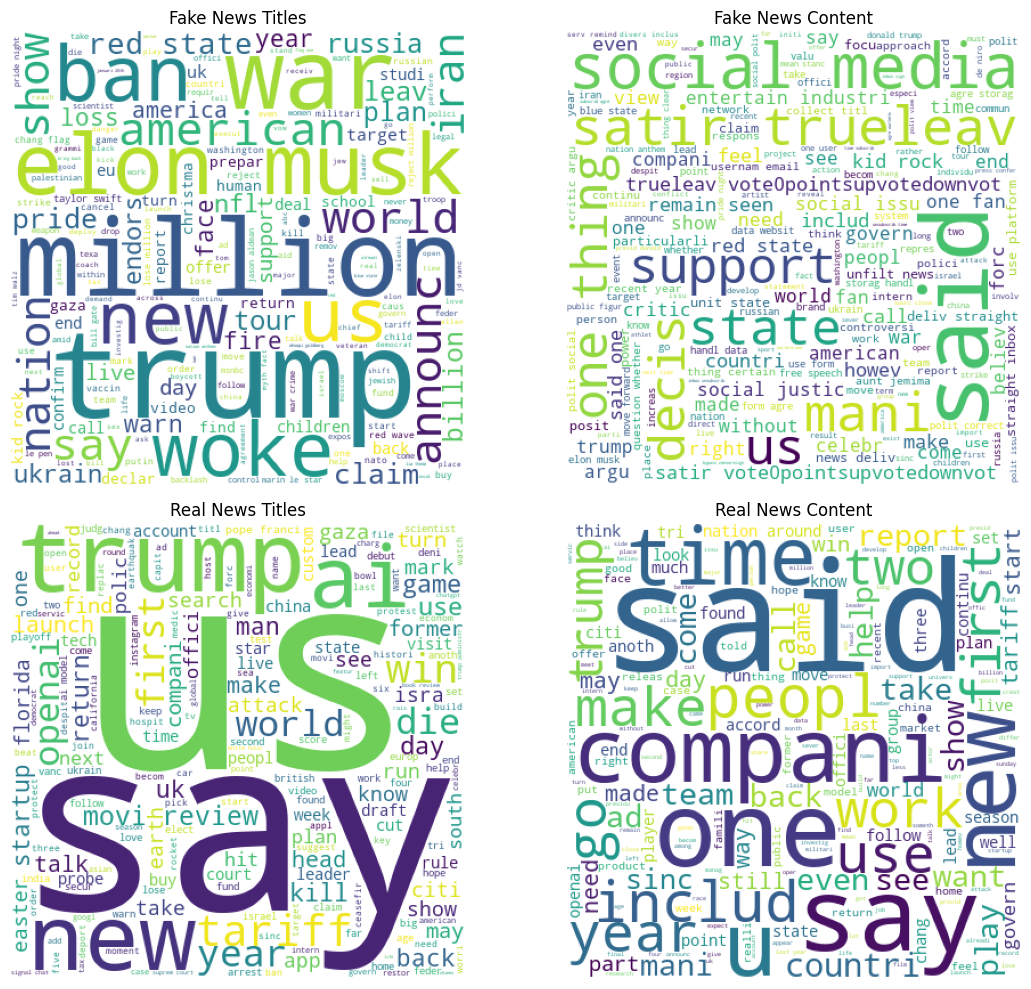

In [413]:
real_titles = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 1]['Title'])
fake_titles = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 0]['Title'])

real_content = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 1]['Content'])
fake_content = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 0]['Content'])

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# titles comparison
ax[0, 0].imshow(WordCloud(width=400, height=400, background_color='white').generate(fake_titles))
ax[0, 0].set_title("Fake News Titles")
ax[0, 0].axis('off')

ax[1, 0].imshow(WordCloud(width=400, height=400, background_color='white').generate(real_titles))
ax[1, 0].set_title("Real News Titles")
ax[1, 0].axis('off')

# content comparison
ax[1, 1].imshow(WordCloud(width=400, height=400, background_color='white').generate(real_content))
ax[1, 1].set_title("Real News Content")
ax[1, 1].axis('off')

ax[0, 1].imshow(WordCloud(width=400, height=400, background_color='white').generate(fake_content))
ax[0, 1].set_title("Fake News Content")
ax[0, 1].axis('off')

plt.tight_layout()
plt.show()

In comparison to Iteration 0, we can see more recent words that appear in current media, such as "tariff" and "Trump"; there is no mention of "Hillary Clinton" anymore. To summarize:

| **News**   | **Titles**                                                                                          | **Content**                                                                                          |
|-----------------|----------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **Fake**   | Big, dramatic words like "million", "war" and "woke" and names of famous people like "Trump", "Elon" and "Musk". | Focus on opinions, social media and words like "support", "satire" and "true". Less about facts, more about feelings or controversy. |
| **Real**   | Words about real events and places like "kill", "win", "Gaza", "Ukraine", "tariff" and "Trump". More factual and direct. | Focus on people, facts and explanations. Common words are "one", "people", "say", "year" and "country." More neutral and informative. |


### Converting the textual data to numerical data 🔁

TF-IDF (Term Frequency-Inverse Document Frequency) is used to convert textual data into numerical features, allowing machine learning models like K-NN and Naive Bayes to process it. It assigns weights to words based on their frequency in a document and their rarity across the dataset, highlighting important terms. The `TfidfVectorizer` transforms the cleaned text data into a numerical array, which is used as the input features (X). The target labels (y), already numerical, represent the classification of each text as real (1) or fake (0).

In [414]:
vectorizer_title = TfidfVectorizer()
vectorizer_content = TfidfVectorizer()

X_title = vectorizer_title.fit_transform(cleaned_dataset['Title']).toarray()
X_content = vectorizer_content.fit_transform(cleaned_dataset['Content']).toarray()

print("Title TF-IDF shape:", X_title.shape)
print("Content TF-IDF shape:", X_content.shape)

Title TF-IDF shape: (940, 3135)
Content TF-IDF shape: (940, 22351)


### Combine the features 🥣
Combine the title and content into one feature matrix.

In [427]:
X = numpy.hstack((X_title, X_content))

### Target variable 🎯 
The target variable is obviously `Label`.

In [428]:
y = cleaned_dataset['Label']

### Splitting into train/test 🪓

We will use 80% of the data for training and the rest - 20% for testing.

In [446]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

There are in total 940 observations, of which 752 are now in the train set and 188 in the test set.


### Modelling 🧬

For iteration 0, I used K-NN for iteration 0 and now, for Iteration 1 - Naive Bayes. The test set will be used to calculate the model's accuracy, which indicates how well it performs.

In [447]:
clf = MultinomialNB()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [448]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Naive Bayes: {accuracy * 100:.2f}%")

Accuracy of Naive Bayes: 90.43%


The accuracy of Naive Bayes is approximately 90%, which is higher than K-NN - 65%.

## Evaluation 🔬

This report evaluates the accuracy of recognising news as fake or real and assesses the model's performance.

In [449]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       107
           1       0.85      0.94      0.89        81

    accuracy                           0.90       188
   macro avg       0.90      0.91      0.90       188
weighted avg       0.91      0.90      0.90       188



It is important to consider the confusion matrix when evaluating a model's performance. The overall accuracy of the model is 90%. The F1-scores for both classes are close (0.91 vs. 0.89), indicating balanced performance with no severe bias toward either class.

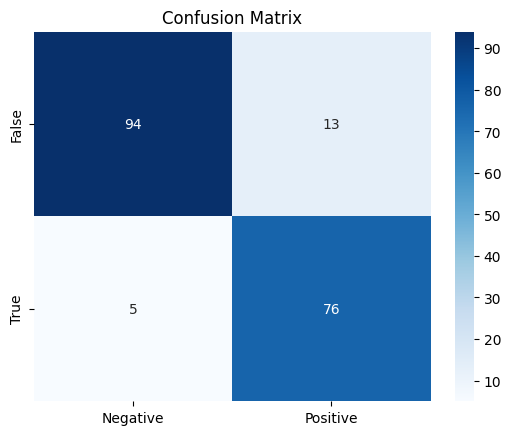

In [450]:
cm = confusion_matrix(y_test, y_pred)

seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix')
plt.show()